In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pysheds
!pip install geopandas
!pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 78.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import fiona
import geopandas as gpd
import warnings
from shapely import geometry, ops
from pysheds.grid import Grid
from pysheds.view import Raster
warnings.filterwarnings('ignore')

%matplotlib inline

### Membaca Data Raster

In [4]:
# Membaca data raster
# ----------------------------

grid = Grid.from_raster('/content/drive/MyDrive/Colab Notebooks/TA/SIDANG/DATA/DEM_SUMATERA.tif')
dem = grid.read_raster('/content/drive/MyDrive/Colab Notebooks/TA/SIDANG/DATA/DEM_SUMATERA.tif')

### Plotting Data DEM

Referensi : https://mattbartos.com/pysheds/

https://mattbartos.com/pysheds/hand.html

https://pygis.io/docs/c_new_vectors.html

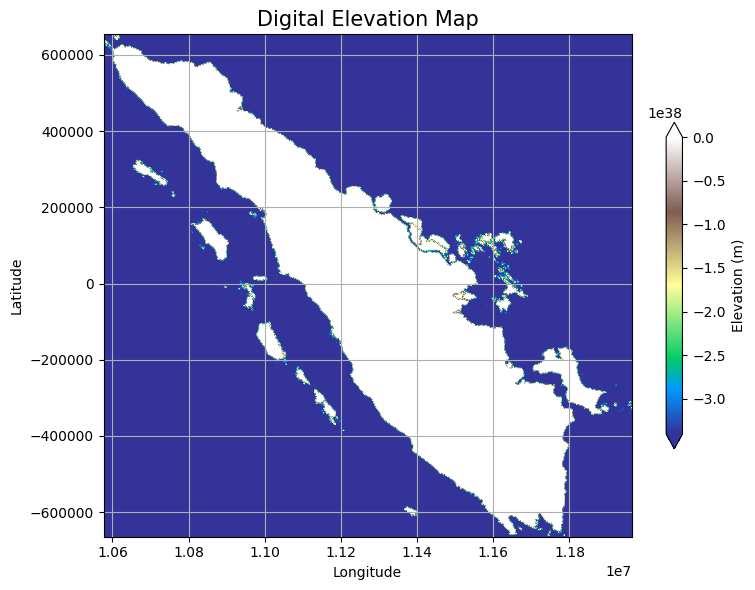

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)', shrink=0.65, extend='both')
plt.grid(zorder=0)
plt.title('Digital Elevation Map', size=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

### Condition The Elevation Data

In [6]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

### Elevation To Flow Direction

In [7]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

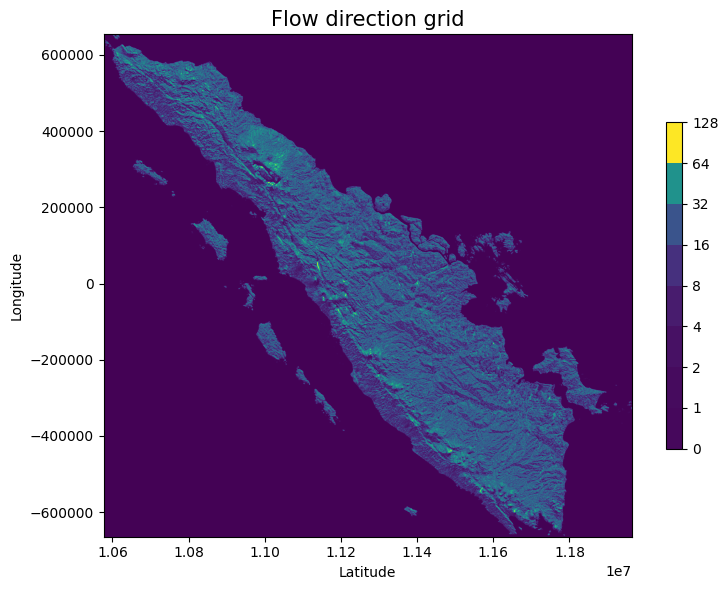

In [8]:
#Plotting 
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap), shrink=0.65)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Flow direction grid', size=15)
plt.grid(zorder=-1)
plt.tight_layout()

flowdir : Generate a flow direction grid from a given digital elevation dataset.

### Mengakumulasi arah aliran

In [9]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

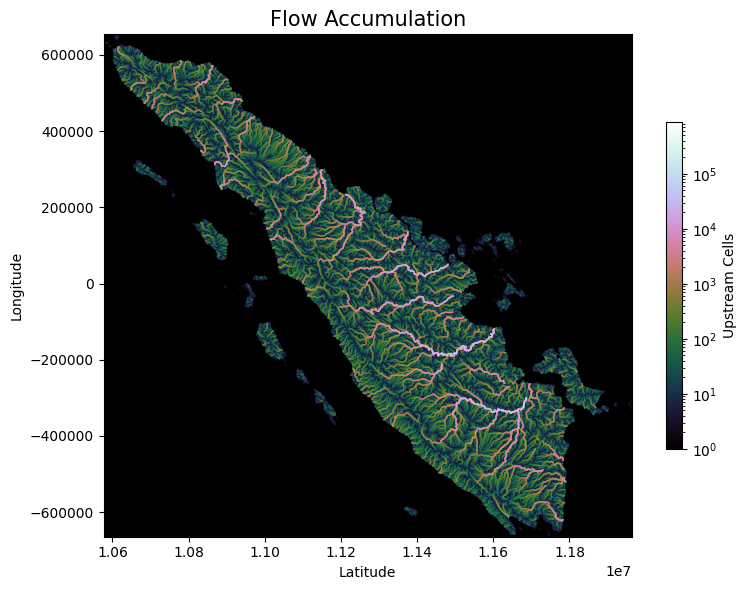

In [10]:
#Plotting 
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells', shrink=0.65)
plt.title('Flow Accumulation', size=15)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.tight_layout()

accumulation : Compute the number of cells upstream of each cell; if weights are given, compute the sum of weighted cells upstream of each cell.

### Menggambarkan DTA dari arah aliran/flow direction

In [21]:
#Baca data excel centroid 
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TA/SIDANG/DATA/koordinat_ff.csv')
data

,OBJECTID,Level0,Level_1,Provinsi,Kabupaten,Kecamatan,Kejadian,Lokasi,Date,Date_new,...,Rumah_RS,Rumah_RR,Jml_Rumah,Pendidikan,Peribadata,Kesehatan,Kantor,Fasum,Jembatan,Kios_Rusak
0,1,13,1371,sumatera barat,kota padang,Kuranji,banjir Bandang,Prov. Sumatera Barat\nKota Padang\nKec. Pauh :...,24-7-2012,2012-7-24,...,55,277,389,2,0,1,0,0,0,0
1,2,13,1371,sumatera barat,kota padang,Nanggalo,banjir Bandang,Kec. Naggalo\nKel. Tabing Banda Gadang\n,14-5-2015,2015-5-14,...,0,0,0,0,0,0,0,0,0,0
2,3,13,1306,sumatera barat,padang pariaman,Padang Sago,banjir Bandang,0,24-7-2012,2012-7-24,...,1,0,2,0,1,0,0,0,0,0
3,4,13,1306,SUMATERA BARAT,PADANG PARIAMAN,Padang Sago,banjir Bandang,Kab. Padang Pariaman\nKec. 2 x 11 Kayu Tanam\n...,10-12-2018,2018-12-10,...,0,0,1,0,2,0,0,0,3,0
4,6,13,1306,SUMATERA BARAT,PADANG PARIAMAN,IV Koto Aur Malintang,BANJIR BANDANG,"Kec. IV Koto Aur Malintang, Ds. III Koto Aur M...",9-1-2021,2021-1-9,...,0,0,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,137,12,1213,sumatera utara,langkat,Batang Serangan,banjir Bandang,sei bingai,29-5-2016,2016-5-29,...,0,0,0,0,0,0,0,0,0,0
121,139,13,1308,SUMATERA BARAT,LIMA PULUH KOTA,Pangkalan Koto Baru,BANJIR BANDANG,KEC. PANGKALAN KOTO BARU\nDS. KOTO ALAM,9-11-2020,2020-11-9,...,0,0,3,0,0,0,1,0,0,0
122,140,13,1308,sumatera barat,lima puluh kota,Pangkalan Koto Baru,banjir Bandang,Prov. Sumatra Barat\nKab. 50 Kota\nKec. Pangka...,28-1-2011,2011-1-28,...,0,0,0,0,0,0,0,0,0,0
123,141,13,1308,SUMATERA BARAT,LIMA PULUH KOTA,Kapur IX,BANJIR BANDANG,KEC. KAPUR IX\nDS. KOTO LAMO,22-7-2020,2020-7-22,...,1,0,1,0,0,0,0,0,0,0


In [ ]:
# Delineate a catchment
for j in (data.index):
  x = data.loc[j,'Lon']
  y = data.loc[j,'Lat']
# Specify pour point/outlet
# x, y =-0.921, 100.438

# Reset view
  grid.viewfinder = fdir.viewfinder

# Compute accumulation
  acc = grid.accumulation(fdir)

# Snap pour point to high accumulation cell
  x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
  catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                         xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
  grid.clip_to(catch)
  clipped_catch = grid.view(catch)

# Calling grid.polygonize without arguments will default to the catchment mask
  shapes = grid.polygonize()
  
  schema = {
      'geometry': 'Polygon',
      'properties': {'LABEL': 'float:16'}
      }
    
  with fiona.open('/content/drive/MyDrive/Colab Notebooks/TA/SIDANG/HASIL/Catchment/Catchment{}.shp'.format(j+1), 'w',
                  driver='ESRI Shapefile',
                  crs=grid.crs.srs,
                  schema=schema) as c:
    i = 0
    for shape, value in shapes:
      rec = {}
      rec['geometry'] = shape
      rec['properties'] = {'LABEL' : str(value)}
      rec['id'] = str(i)
      c.write(rec)
      i += 1

  shp = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/TA/SIDANG/HASIL/Catchment/Catchment{}.shp'.format(i+1))
  shp.head()

In [ ]:
# copy GeoDataFrame
points = shp.copy()
# change geometry 
points['geometry'] = points['geometry'].centroid
points.head()

,LABEL,geometry


Text(0.5, 1.0, 'Delineated Catchment')

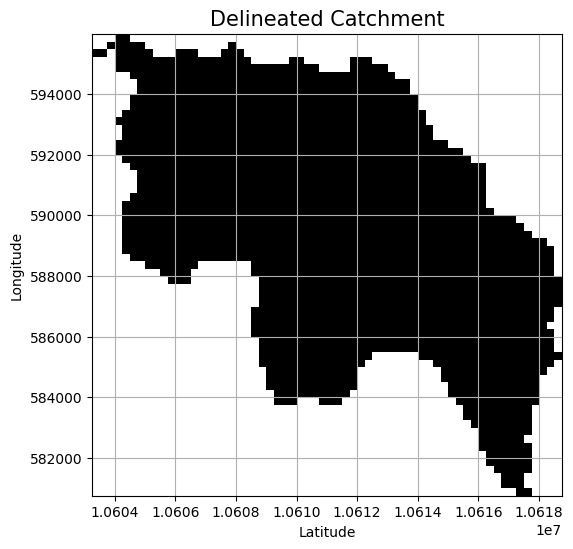

In [ ]:
# Plotting
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1.5, cmap='Greys_r')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Delineated Catchment', size=15)

snap_to_mask : Snaps a set of points to the nearest nonzero cell in a boolean mask; useful for finding pour points from an accumulation raster

### Ubah Ke Bentuk Shapefile

Referensi: https://github.com/mdbartos/pysheds/blob/master/recipes/write_shapefile.ipynb

In [ ]:
# Calling grid.polygonize without arguments will default to the catchment mask
shapes = grid.polygonize()

# Is equivalent to...
#shapes = catch.polygonize(grid.mask.astype(np.uint8))

In [ ]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('/content/drive/MyDrive/Colab Notebooks/TA/Data Sungai/Catchment1.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

In [ ]:
shp = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/TA/Data Sungai/Catchment1.shp')
shp.head()

,LABEL,geometry
0,1,"POLYGON ((10603249.574 595495.826, 10603749.57..."
1,1,"POLYGON ((10603999.574 595995.826, 10604499.57..."


### Ubah Shapefile ke Titik Berat/Centroid

In [ ]:
# copy GeoDataFrame
points = shp.copy()
# change geometry 
points['geometry'] = points['geometry'].centroid
points.head()

,LABEL,geometry
0,1,POINT (100.42925 -0.79440)


### Membaca Data Kondisi Atmosfer (Netcdf)

In [ ]:
#Load data sebagai data array
cape=xr.load_dataarray('/content/drive/MyDrive/Bismillah TA/TA/Data/cape.nc')

#min_lat = -0.7943954
#max_lat = -0.5443954
#min_lon = 100.179249
#max_lon = 100.429249

#min_lat = -0.8
#max_lat = -0.55
#min_lon = 100.25
#max_lon = 100.5
        
#cropped_cape = cape.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))
cropped_cape = cape.sel(longitude=100.429, latitude=-0.794, method='nearest')
df = cropped_cape.to_dataframe()
df = pd.DataFrame(df)

In [ ]:
df

,longitude,latitude,cape
time,,,
2011-01-01 00:00:00,100.5,-0.85,51.900391
2011-01-01 01:00:00,100.5,-0.85,75.402344
2011-01-01 02:00:00,100.5,-0.85,53.859375
2011-01-01 03:00:00,100.5,-0.85,28.398438
2011-01-01 04:00:00,100.5,-0.85,9.792969
...,...,...,...
2021-12-31 19:00:00,100.5,-0.85,123.384766
2021-12-31 20:00:00,100.5,-0.85,102.820312
2021-12-31 21:00:00,100.5,-0.85,141.011719


In [ ]:
cape

<xarray.DataArray 'cape' (time: 96432, latitude: 49, longitude: 57)>
array([[[ 527.8086  ,  477.8672  ,  447.51172 , ...,  312.37695 ,
          334.9004  ,  331.9629  ],
        [ 655.1094  ,  411.2793  ,  279.08398 , ...,  359.38086 ,
          424.99023 ,  435.76172 ],
        [ 493.53516 ,  251.66406 ,   63.652344, ...,  292.79297 ,
          364.27734 ,  428.90625 ],
        ...,
        [ 375.04883 ,  512.1406  ,  560.12305 , ..., 1405.2031  ,
         1541.3164  , 1560.9023  ],
        [ 334.9004  ,  454.3672  ,  510.1836  , ...,  986.0918  ,
         1354.2832  , 1540.3379  ],
        [ 342.73438 ,  433.80273 ,  484.72266 , ...,  828.4336  ,
         1111.4336  , 1292.5918  ]],

       [[ 407.36328 ,  468.07617 ,  464.1582  , ...,  249.70703 ,
          248.72656 ,  276.14648 ],
        [ 447.51172 ,  397.5703  ,  309.43945 , ...,  340.7754  ,
          364.27734 ,  359.38086 ],
        [ 422.05078 ,  307.48047 ,  125.34375 , ...,  315.31445 ,
          376.02734 ,  352.5254  ],
...
        [ 417.15625 ,  453.38672 ,  428.90625 , ...,  518.9961  ,
          518.0176  ,  518.9961  ],
        [ 345.67188 ,  355.4629  ,  298.66797 , ...,  486.68164 ,
          517.0371  ,  575.791   ],
        [ 295.73047 ,  278.10352 ,  208.57812 , ...,  287.89648 ,
          393.6543  ,  516.0586  ]],

       [[ 308.46094 ,  435.76172 ,  487.66016 , ...,  154.7207  ,
          227.1836  ,  279.08398 ],
        [ 235.01758 ,  251.66406 ,  278.10352 , ...,  192.91016 ,
          238.93555 ,  275.16602 ],
        [ 208.57812 ,  151.7832  ,  134.15625 , ...,  239.91406 ,
          261.45703 ,  277.125   ],
        ...,
        [ 502.3496  ,  571.875   ,  568.9375  , ...,  566.      ,
          607.12695 ,  646.2969  ],
        [ 463.1797  ,  491.57812 ,  439.67773 , ...,  593.41797 ,
          660.9844  ,  713.8633  ],
        [ 431.84375 ,  423.03125 ,  340.7754  , ...,  413.23828 ,
          556.20703 ,  649.2344  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 95.0 95.25 95.5 95.75 ... 108.5 108.8 109.0
  * latitude   (latitude) float32 5.9 5.65 5.4 5.15 ... -5.35 -5.6 -5.85 -6.1
  * time       (time) datetime64[ns] 2011-01-01 ... 2021-12-31T23:00:00
Attributes:
    units:      J kg**-1
    long_name:  Convective available potential energy